# Task 1

## 1.1 Importing libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1.2 Read file

In [2]:
path = './paris_temperature.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df.set_index('datetime', inplace=True)

In [5]:
df.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,"Paris,France",26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,...,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999...",None
2023-10-02,"Paris,France",27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,...,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999...",None
2023-10-03,"Paris,France",22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,...,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157...",None
2023-10-04,"Paris,France",18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,...,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145...",None
2023-10-05,"Paris,France",19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,...,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145...",None


## 1.3 Plotting the Paris temperature column

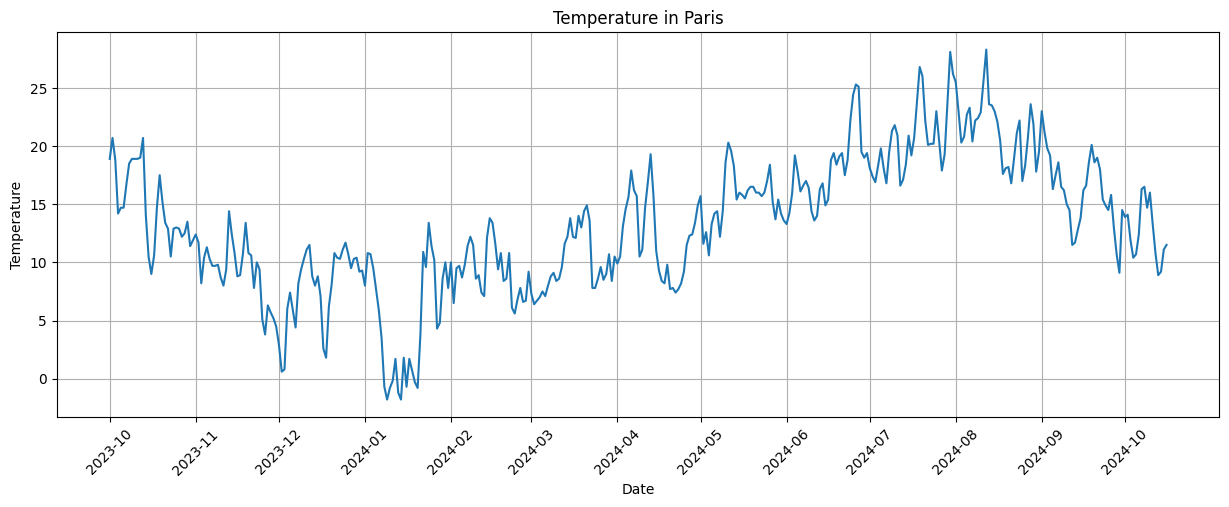

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

# Task 3

## 3.1 Determining Numerical Features and Categorical Features

In [7]:
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 9 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations', 'datetime']


# Task 4

## 4.1

### Def

The ARIMA model is a combination of AR and MA models, with an added component for handling non-stationary data through differencing. The model is represented as $ARIMA(p, d, q)$, where:

* $p$ is the order of the AR part,
* $d$ is the number of differencing operations to make the series stationary,
* $q$ is the order of the MA part.

An ARIMA model first applies differencing $d$ times to the time series and then fits an ARMA model (combination of AR and MA) on the differenced data.

For example, if the differenced series is denoted by $X'_t$​, the ARIMA model can be written as:
$$ X'_t = c + \sum_{i=1}^p \phi_i X'_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i} + \varepsilon_t.$$

Steps for Applying ARIMA:

* Differencing: If the original time series is non-stationary, apply differencing until the series becomes stationary. This removes trends and makes the series more stable.
* Fit $AR(p)$ and $MA(q)$: After differencing, apply an AR and MA model to the stationary series, with orders determined by analyzing autocorrelation and partial autocorrelation plots.
* Estimate Parameters: Use statistical techniques to estimate the model parameters.

### Code

In [8]:
data = df.drop(columns=categorical_features)
train = data['2023-10-01':'2024-09-16'] 
test = data['2024-09-16':]

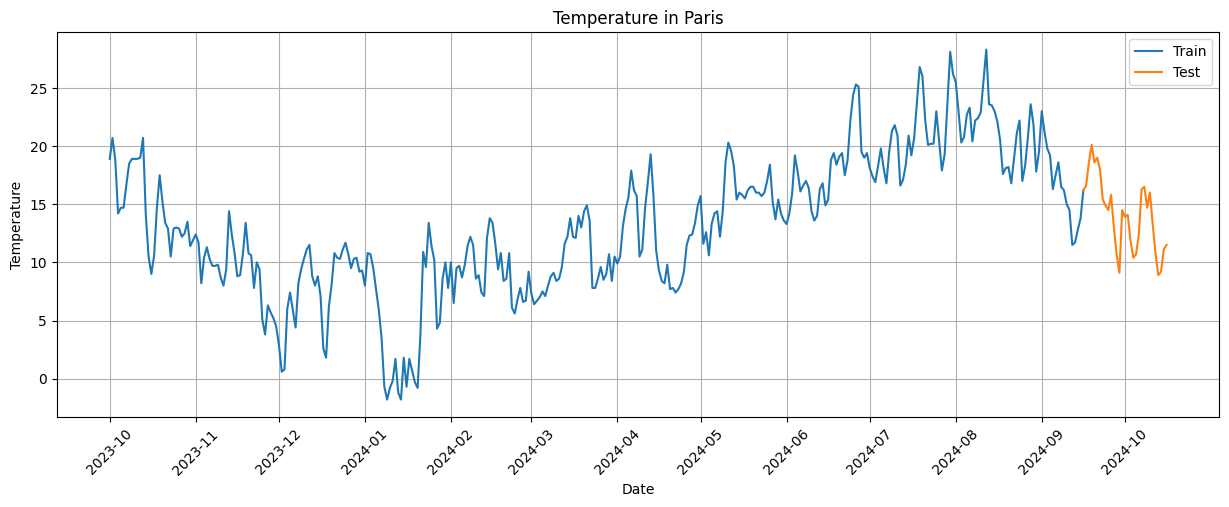

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['temp'], label='Train')
plt.plot(test.index, test['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

In [10]:
# Differencing Order
data = data['temp']

In [11]:
# Perform ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data) 
print('ADF Statistic:', result[0]) 
print('p-value:', result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): 
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -2.74262288763004
p-value: 0.06694856335880939
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value is greater than 0.05. This mean that the data is not stationary so we apply the first diff for this one

In [12]:
if result[1] > 0.05: 
    data_diff = data.diff().dropna()
    result_diff = adfuller(data_diff) 
    print('ADF Statistic (1st diff):', result_diff[0]) 
    print('p-value (1st diff):', result_diff[1]) 
    print('Critical Values (1st diff):') 
    for key, value in result_diff[4].items(): 
        print(f'\t{key}: {value:.3f}')

ADF Statistic (1st diff): -14.794239815296415
p-value (1st diff): 2.147810770410271e-27
Critical Values (1st diff):
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value now is signifincantly lower that 0.05 and it's considered stationary so we go to the next step

In [13]:
train = data_diff['2023-10-01':'2024-09-16'] 
test = data_diff['2024-09-16':]

In [14]:
# Using auto_arima
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error,r2_score

arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True) 

forecast = arima_model.predict(n_periods=len(test))
rmse = root_mean_squared_error(test, forecast) 
aic = arima_model.aic() 
bic = arima_model.bic() 
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"Best ARIMA parameters: p={arima_model.order[0]}, d={arima_model.order[1]}, q={arima_model.order[2]}") 
print(f"AIC: {aic}, BIC: {bic}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1481.647, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1511.760, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1509.870, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1507.705, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1480.403, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1497.768, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1507.334, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1480.813, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1482.686, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1480.265, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1495.407, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1481.023, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1486.617, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1484.261, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

Best model so far come with lowest AIC at p = 2, q = 1

In [15]:
# Using base arima
from statsmodels.tsa.arima.model import ARIMA
import itertools

p = d = q = range(0,3)
order = list(itertools.product(p, [0], q))

results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC', 'Loglik', 'RMSE'])
for param in order: 
    try: 
        model = ARIMA(train, order=param) 
        result = model.fit() 
        forecast = result.forecast(steps=len(test)) 
        aic = result.aic 
        bic = result.bic 
        loglik = result.llf 
        rmse = root_mean_squared_error(test, forecast) 
        mape = mean_absolute_percentage_error(test, forecast)
        r2 = r2_score(test, forecast)
        results = pd.concat([results, pd.DataFrame({'p': [param[0]], 'd': [param[1]], 'q': [param[2]], 'AIC': [aic], 'BIC': [bic], 'Loglik': [loglik], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})], ignore_index=True)
    except Exception as e: 
        print(f"Error with parameters {param}: {e}")
        
best_model = results.loc[results['AIC'].idxmin()] 
print("Best ARIMA parameters found:") 
print(best_model)

d:\Workspace\Machine_Learning\aiengine\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Workspace\Machine_Learning\aiengine\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Workspace\Machine_Learning\aiengine\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Temp\ipykernel_25496\2885539149.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the 

Best ARIMA parameters found:
p                   2
d                   0
q                   1
AIC       1482.251975
BIC       1501.555906
Loglik    -736.125988
RMSE         1.981063
MAPE          1.03395
R2          -0.007315
Name: 7, dtype: object


## 4.2

### DEF

*Types of Exponential Smoothing:*

* Simple Exponential Smoothing (SES)
* Holt's Linear Trend Model
* Holt-Winters Seasonal Model

1. **Simple Exponential Smoothing (SES)**:

This method is used for time series data without a trend or seasonality.

Formula:

$$ 𝑆_𝑡 = \alpha 𝑋_𝑡 + (1 - \alpha) S_{t-1}.$$

Where:

* $𝑆_𝑡$ is the smoothed statistic (forecast) at time $𝑡$
* $𝑋_𝑡$ is the actual value at time $𝑡$
* $𝑆_{𝑡−1}$ is the smoothed statistic at time ${𝑡−1}$
* $\alpha$ is the smoothing factor $(0 < 𝛼 < 1)$

2. Holt's Linear Trend Model
This method is used for data with a trend.

2.1. **Level Equation ($L_t$)**:

$$ L_t = \alpha X_t + (1- \alpha) (S_{t-1} + T_{t-1}).$$

Where: 
* $L_t$ is Level at time $t$
* $X_t$ is actual value at time $t$
* $L_{t-1}$ is level at time $t-1$
* $T_{t-1}$ is trend at time $t-1$
* $\alpha$ is level smoothing factor $(0 < \alpha < 1)$

2.2. **Trend Equation** 

$$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}.$$ 

Where:

* $𝑇_𝑡$ is Trend at time $𝑡$
* $L_t$ is level at time $t$
* $\beta$ is trend smoothing factor

2.3. **Forecast Equation** 

$$ F_{t+k} = L_t + k T_t.$$

Where:

* $F_{t + k}$ is forecast for k periods ahead
* $k$ is number of periods ahead

3. Holt-Winters Seasonal Model
This method is used for data with both trend and seasonality.

3.1. **Level Model:**

$$ L_t = \alpha (X_t - S_{t-s} + (1- \alpha) (S_{t-1} + T_{t-1}).$$

Where:

* $S_{t-s}$ is seasonal component at time $t-s$

3.2. **Trend Equation:**

$$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}.$$

3.3. **Seasonal Equation:**

$$ S_t = \gamma (X_t - L_t) + (1-\gamma) S_{t-s}.$$

Where: 

* $\gamma$ is Seasonal smoothing factor

3.4. **Forecast Equation:**

$$ F_{t+k} = L_t + k T_t + S_{t-s+k}.$$

Summary
Simple Exponential Smoothing is for data without trend or seasonality.

Holt's Linear Trend Model is for data with a trend.

Holt-Winters Seasonal Model is for data with trend and seasonality, either additive or multiplicative.

### Code

In [16]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit() 
es_forecast = es_model.forecast(len(test))

rmse_es = root_mean_squared_error(test, es_forecast) 
r2_es = r2_score(test, es_forecast) 
mape_es = mean_absolute_percentage_error(test, es_forecast) 
aic_es = es_model.aic 
bic_es = es_model.bic 

# Compare results 
print(f"ARIMA: RMSE={rmse}, R²={r2}, MAPE={mape},\n AIC={aic}, BIC={bic}, LogLik={loglik}\n") 
print(f"ES: RMSE={rmse_es}, R²={r2_es}, MAPE={mape_es},\n AIC={aic_es}, BIC={bic_es}\n")

ARIMA: RMSE=1.9667000411963154, R²=0.00723777856395913, MAPE=1.015063432263862,
 AIC=1483.6421978135454, BIC=1506.8069151543407, LogLik=-735.8210989067727

ES: RMSE=2.030255404728604, R²=-0.0579626578727801, MAPE=1.0464358086161074,
 AIC=536.3138072288275, BIC=598.0863868042813



d:\Workspace\Machine_Learning\aiengine\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In conclution, ARIMA yields a better performance and result 

### Metrics

Metrics are standards of measurement used to evaluate and compare the performance of different models or systems. In data science and machine learning, metrics are crucial for assessing the accuracy, performance, and effectiveness of algorithms and models. They help determine how well a model performs on a given task and guide improvements and optimizations.

1. Root Mean Squared Error (RMSE):

* Measures the average magnitude of the errors without considering their direction.
* Lower values indicate better performance.
* Formula:
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}.$$

2. R2 Score

* Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.
* Values range from 0 to 1, with higher values indicating better performance.
* Formula:
$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}i)^2}{\sum{i=1}^{n} (y_i - \bar{y})^2}.$$

3. Mean Absolute Percentage Error (MAPE):

* Measures the accuracy as a percentage, indicating the average absolute percentage error between predicted and actual values.
* Lower values indicate better performance.
* Formula:
$$ \text{MAPE} = \frac{1}{n}\sum_{i=1}^n|{\frac{y_i - \hat{y}_i}{y_i}}|\times100.$$

4. Akaike Information Criterion (AIC):

* Used for model comparison, it estimates the relative quality of statistical models.
* Lower AIC values indicate a better fit.
* Formula:
$$ \text{AIC} = 2k - 2\ln(L).$$

* Where $k$ is the number of parameters, and $L$ is the maximized value of the likelihood function.

5. Bayesian Informaftion Criterion (BIC):
* Similar to AIC, but includes a stronger penalty for models with more parameters.
* ower BIC values indicate a better fit.
* Formula:

$$ \text{BIC} = \ln(n)k - 2\ln(L).$$

* Where $n$ is the number of data points, $k$ is the number of parameters, and $L$ is the maximized value of the likelihood function.

6. Log-Likelihood:

* For a set of observed data points ${𝑥_1, x_2, ..., x_n}$ and a statistical model with parameters $\theta$, the log-likelihood $\ell(\theta)$ is given by:

$$ ell(\theta) = \ln L(\theta) = \sum_{i=1}^{n} \ln f(x_i; \theta).$$

Where:
* $L(\theta)$ is the likelihood function
* $f(x_i; \theta)$ is the probability density (or mass) function of $x_i$ given the parameter $\theta$


In [17]:
!nvidia-smi

Wed Nov 20 14:35:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3              18W /  30W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--